In [1]:
import scanpy as sc
from sklearn.model_selection import train_test_split
from qiskit_machine_learning.utils import algorithm_globals

# Load the AnnData object
fname = 'mouse_colon.h5ad'
adata = sc.read_h5ad(fname)

In [2]:
# Fix this bug on write_h5ad matlab function
var_names0 = adata.var_names.str.extract(r"\('?(.*?)'?\)", expand=False)
var_names0 = var_names0.str.replace(",", "", regex=False)  # Remove any commas
var_names0 = var_names0.str.replace("'", "", regex=False)
adata.var_names = var_names0
del var_names0

In [3]:
# Set the random seed for reproducibility
algorithm_globals.random_seed = 42

# Split indices into training and testing
train_indices, test_indices = train_test_split(
    range(adata.shape[0]), train_size=0.8, random_state=algorithm_globals.random_seed
)

# Subset AnnData using the indices
adata_train = adata[train_indices].copy()
adata_test = adata[test_indices].copy()

# Verify shapes and content
print(f"Training set shape: {adata_train.shape}")
print(f"Testing set shape: {adata_test.shape}")

Training set shape: (88278, 16149)
Testing set shape: (22070, 16149)


In [4]:
# Normalize and log-transform data
adata_train.layers["counts"] = adata_train.X.copy()
sc.pp.normalize_total(adata_train)
sc.pp.log1p(adata_train)
sc.pp.highly_variable_genes(adata_train, n_top_genes=5000)

In [5]:
# Normalize and log-transform data
adata_test.layers["counts"] = adata_test.X.copy()
sc.pp.normalize_total(adata_test)
sc.pp.log1p(adata_test)
sc.pp.highly_variable_genes(adata_test, n_top_genes=5000)

In [6]:
hvg_train = adata_train.var.index[adata_train.var["highly_variable"]].tolist()
hvg_test = adata_test.var.index[adata_test.var["highly_variable"]].tolist()
overlap = set(hvg_train) & set(hvg_test)  # Intersection
print(f"Number of overlapping HVGs: {len(overlap)}")
print("Example overlapping HVGs:", list(overlap)[:10])  # Show a few examples


Number of overlapping HVGs: 4139
Example overlapping HVGs: ['Notch1', 'Nhlh1', 'Kcnab2', 'Tcp10b', 'Tcim', 'P3h2', 'Ikbkb', 'S1pr4', 'Slc27a1', 'Miip']


In [7]:
# Check if 'Nr4a1' exists in hvg_test
gene = 'Nr4a1'
if gene in hvg_test:
    print(f"'{gene}' is in hvg_test!")
else:
    print(f"'{gene}' is NOT in hvg_test.")

# Check if 'Nr4a1' exists in hvg_test
if gene in hvg_train:
    print(f"'{gene}' is in hvg_train!")
else:
    print(f"'{gene}' is NOT in hvg_train.")

'Nr4a1' is in hvg_test!
'Nr4a1' is in hvg_train!


In [8]:
# Ensure overlapping HVGs are marked in adata_train and adata_test
overlap = set(hvg_train) & set(hvg_test)  # Intersection of HVGs

# Update the 'highly_variable' column in adata_train
adata_train.var['highly_variable'] = adata_train.var.index.isin(overlap)

# Update the 'highly_variable' column in adata_test
adata_test.var['highly_variable'] = adata_test.var.index.isin(overlap)

# Verify updates
print("Updated 'highly_variable' in adata_train:")
print(adata_train.var['highly_variable'].value_counts())
print("\nUpdated 'highly_variable' in adata_test:")
print(adata_test.var['highly_variable'].value_counts())


Updated 'highly_variable' in adata_train:
highly_variable
False    12010
True      4139
Name: count, dtype: int64

Updated 'highly_variable' in adata_test:
highly_variable
False    12010
True      4139
Name: count, dtype: int64


Number of overlapping HVGs: 4139
Example overlapping HVGs: ['Notch1', 'Nhlh1', 'Kcnab2', 'P3h2', 'Tcim', 'Tcp10b', 'Ikbkb', 'S1pr4', 'Slc27a1', 'Miip']


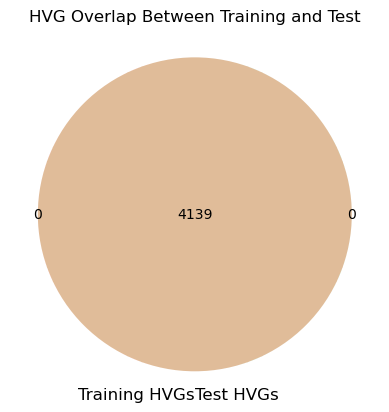

In [9]:
hvg_train = adata_train.var.index[adata_train.var["highly_variable"]].tolist()
hvg_test = adata_test.var.index[adata_test.var["highly_variable"]].tolist()
overlap = set(hvg_train) & set(hvg_test)  # Intersection
print(f"Number of overlapping HVGs: {len(overlap)}")
print("Example overlapping HVGs:", list(overlap)[:10])  # Show a few examples
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

venn2([set(hvg_train), set(hvg_test)], set_labels=("Training HVGs", "Test HVGs"))
plt.title("HVG Overlap Between Training and Test")
plt.show()


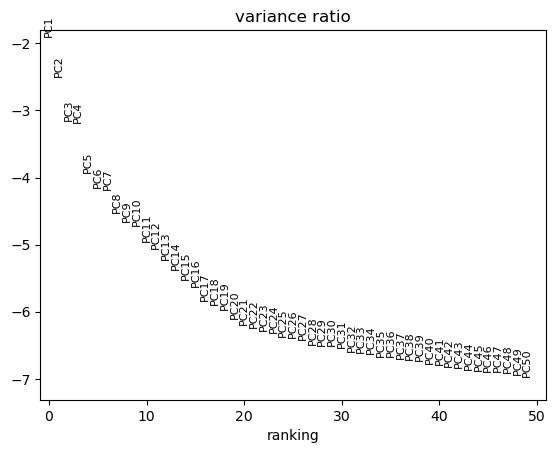

c:\Users\ssromerogon\.conda\envs\qnn-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\ssromerogon\AppData\Local\Temp\ipykernel_15160\999741055.py:11: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_train, flavor="leidenalg", n_iterations=2)


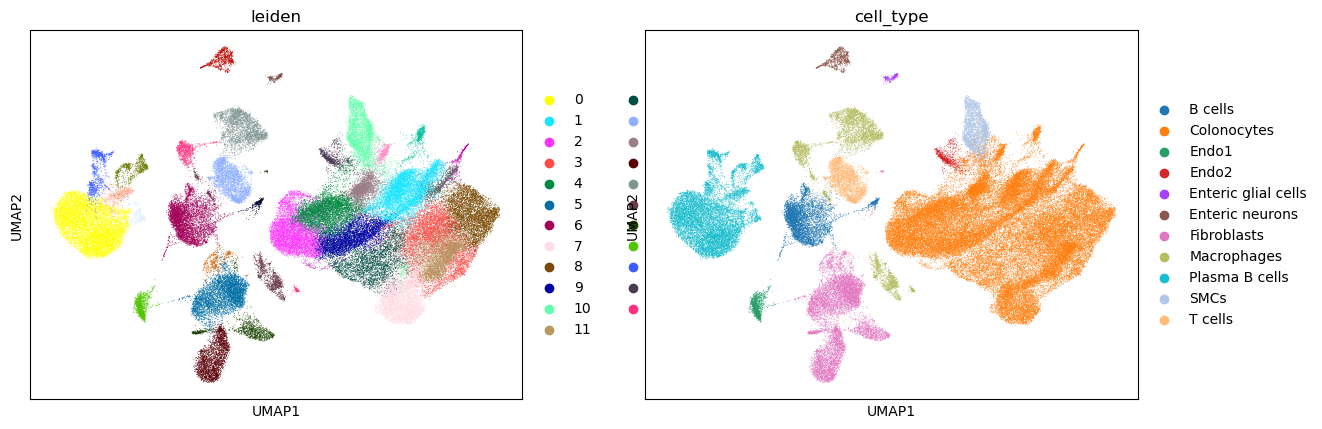

In [10]:
# Analyze training data
# Normalize and log-transform data
#adata_train.X = adata_train.layers["counts"].copy()
#sc.pp.normalize_total(adata_train)
#sc.pp.log1p(adata_train)
npcs = 50
sc.tl.pca(adata_train, n_comps=npcs)
sc.pl.pca_variance_ratio(adata_train, n_pcs=npcs, log=True)
sc.pp.neighbors(adata_train)
sc.tl.umap(adata_train)
sc.tl.leiden(adata_train, flavor="leidenalg", n_iterations=2)
sc.pl.umap(adata_train, color=["leiden", 'cell_type'])

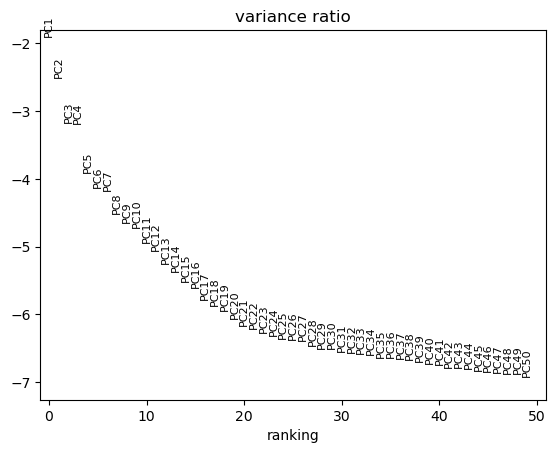

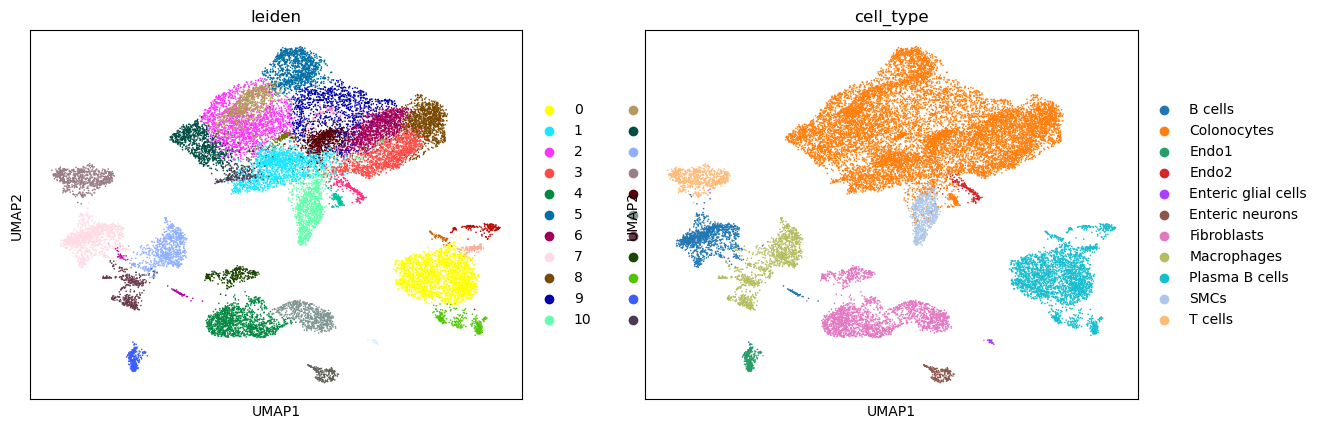

In [11]:

# Analyze testing data
sc.tl.pca(adata_test, n_comps=npcs)
sc.pl.pca_variance_ratio(adata_test, n_pcs=npcs, log=True)
sc.pp.neighbors(adata_test)
sc.tl.umap(adata_test)
sc.tl.leiden(adata_test, flavor="leidenalg", n_iterations=2)
sc.pl.umap(adata_test, color=["leiden", "cell_type"])

In [12]:
import numpy as np
print(np.min(adata_train.X), np.max(adata_train.X), np.mean(adata_train.X))
print(np.min(adata_test.X), np.max(adata_test.X), np.mean(adata_test.X))


0.0 7.356148304483249 0.07290530483890666
0.0 7.422922933064359 0.07266139598331785


In [13]:
# Classical solver
from sklearn.svm import SVC

train_labels = adata_train.obs['cell_type']
test_labels =  adata_test.obs['cell_type']
Xtrain = adata_train.obsm['X_pca']
Xtest = adata_test.obsm['X_pca']

svc = SVC()
_ = svc.fit(Xtrain, train_labels)  # suppress printing the return value
train_score_c4 = svc.score(Xtrain, train_labels)
test_score_c4 = svc.score(Xtest, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c4:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c4:.2f}")

Classical SVC on the training dataset: 1.00
Classical SVC on the test dataset:     0.87


In [14]:
from qiskit.circuit.library import ZZFeatureMap

train_labels = adata_train.obs['cell_type']
test_labels =  adata_test.obs['cell_type']
Xtrain = adata_train.obsm['X_pca'][:, :10]
Xtest = adata_test.obsm['X_pca'][:, :10]

num_features = Xtrain.shape[1]


In [15]:
feature_map = ZZFeatureMap(feature_dimension=num_features, reps=2)
print(feature_map.num_qubits)  # Should match num_features
print(feature_map.depth())     # Check depth for debugging
#feature_map.decompose().draw(output="mpl", style="clifford", fold=20)


10
1


In [16]:
# # Decompose and iterate through individual operations
# for idx, gate in enumerate(feature_map.decompose()):
#     print(f"Gate {idx}: {gate}")
# print(feature_map.decompose())


In [17]:
from qiskit_machine_learning.optimizers import COBYLA

optimizer = COBYLA(maxiter=50)

from qiskit.primitives import StatevectorSampler as Sampler

sampler = Sampler()

# Define ansatz
from qiskit.circuit.library import RealAmplitudes
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
#print(ansatz.decompose())

In [18]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [19]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


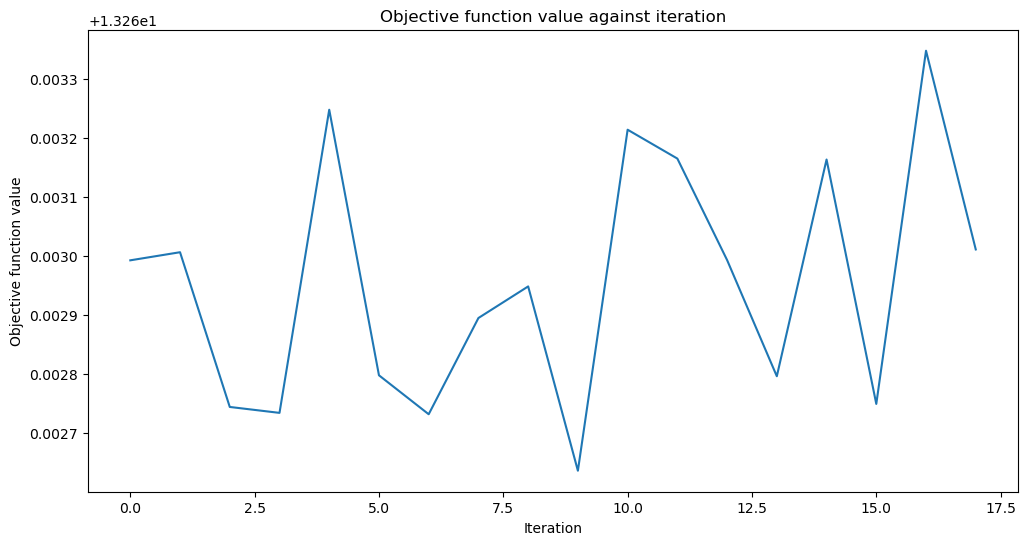

In [ ]:
import numpy as np


# Convert train and test labels to NumPy arrays
train_labels = np.array(adata_train.obs['cell_type'])
test_labels = np.array(adata_test.obs['cell_type'])

# Save an untrained model to disk first
vqc.save("vqc_checkpoint.model")

batch_size = Xtrain.shape[0]
#batch_size = 10000  # Choose a size that fits your memory
num_batches = (len(Xtrain) + batch_size - 1) // batch_size  # Ceiling division


for i in range(num_batches):
    # Load the model
    vqc = VQC.load("vqc_checkpoint.model")
    vqc.warm_start = True  # Allow training continuation

    # Prepare the current batch
    start = i * batch_size
    end = min(start + batch_size, len(Xtrain))  # Ensure we don't exceed the array size
    batch_features = Xtrain[start:end]
    batch_labels = train_labels[start:end]

    # Train on the current batch
    vqc.fit(batch_features, batch_labels)

    # Save the model after each batch
    vqc.save("vqc_checkpoint.model")

# Final evaluation (optional)
train_score = vqc.score(Xtrain, train_labels)
print("Train score:", train_score)

test_score = vqc.score(Xtest, test_labels)
print("Test score:", test_score)
#print(f"Classical SVC on the training dataset: {train_score_c4:.2f}")
#print(f"Classical SVC on the test dataset:     {test_score_c4:.2f}")


In [ ]:
from qiskit.circuit.library import EfficientSU2

train_labels = adata_train.obs['cell_type']
test_labels =  adata_test.obs['cell_type']
Xtrain = adata_train.obsm['X_pca'][:, :10]
Xtest = adata_test.obsm['X_pca'][:, :10]

num_features = Xtrain.shape[1]

feature_map = EfficientSU2(feature_dimension=num_features, reps=2)
print(feature_map.num_qubits)  # Should match num_features
print(feature_map.depth())     # Check depth for debugging
#feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

from qiskit_machine_learning.optimizers import COBYLA

optimizer = COBYLA(maxiter=50)

from qiskit.primitives import StatevectorSampler as Sampler

sampler = Sampler()

# Define ansatz
from qiskit.circuit.library import RealAmplitudes
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
#print(ansatz.decompose())

from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()


    

In [ ]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc2 = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)



In [ ]:
import numpy as np


# Convert train and test labels to NumPy arrays
train_labels = np.array(adata_train.obs['cell_type'])
test_labels = np.array(adata_test.obs['cell_type'])

# Save an untrained model to disk first
vqc2.save("vqc_checkpoint.model")

batch_size = 1000  # Choose a size that fits your memory
num_batches = (len(Xtrain) + batch_size - 1) // batch_size  # Ceiling division


for i in range(num_batches):
    # Load the model
    vqc2 = VQC.load("vqc_checkpoint.model")
    vqc2.warm_start = True  # Allow training continuation

    # Prepare the current batch
    start = i * batch_size
    end = min(start + batch_size, len(Xtrain))  # Ensure we don't exceed the array size
    batch_features = Xtrain[start:end]
    batch_labels = train_labels[start:end]

    # Train on the current batch
    vqc2.fit(batch_features, batch_labels)

    # Save the model after each batch
    vqc2.save("vqc_checkpoint.model")

# Final evaluation (optional)
test_score = vqc2.score(Xtest, test_labels)
print("Test score:", test_score)